# Machine Learning and Computer Vision
## Assigment 2

---

This assignment contains 3 programming exercises. Please review the pdf file for more detail information.


## Problem 1: Sampling and Quantization

In this problem, we intend to study the effects of sampling and quantization on digital images.
Your job is to write a function with the following specifications (you may use loops if necessary):

(i) The function takes one input: the image file name, 'peppers.png'.

(ii) The input image is assumed to be grayscale.

(iii) Sample the image in spatial domain with a sampling 
rate of 10 (your image should be approximately 10 times smaller along width and height, do not use any numpy functions).

(iv) Do a 5-level uniform quantization of the sampled image so that the bins cover the whole range of grayscale values (0 to 255). You should not use any numpy functions for this.

(v) The function returns one output: the sampled and quantized image.


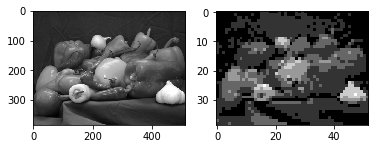

In [25]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt

def sampling_quantization(img):
    m, n = img.shape
    #sampling
    rate = 10
    img_res = img[::rate, ::rate]
    #quantization
    level = 5
    for i in range(m):
        for j in range(n):
            for k in range(level):
                if 255*k/5 <= img[i,j] < 255*(k+1)/5:
                    img[i,j]=255*k/5
    return img_res

#Import image here
img = imread('peppers.png')
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')

#Sample call and Plotting code
res = sampling_quantization(img)
plt.subplot(1,2,2)
plt.imshow(res, cmap='gray')


## Problem 2 Image shift
Shifting an image x of size (n1, n2) in a direction (k, l) consists in creating a new image xshifted of size
(n1, n2) such that

<img src="markdown/fig1.png">

In practice, boundary conditions should be considered for pixels (i, j) such that (i + k, j + l) not equal to [0, n1-1] x [0, n2-1]. 

A typical example is to consider periodical boundary conditions such that

<img src="markdown/fig2.png">

Create in imshift function implementing the shifting of an image x in periodical boundary, such as the following image(b) Shifted in the direction (k,l) by (+100,-50):
<img src="markdown/fig3.png">

Hint: First write it using loops, and next try to get rid of the loops.

256 256


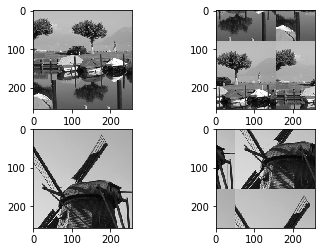

In [127]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt

def imshift(x, k, l):
    m, n = x.shape
    xshifted = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            xshifted[i, j] = x[(i+k)%m, (j+l)%n]
    return xshifted

# when k or l is 0, it causes error
def imshift2(x, k, l):
    m, n = x.shape
    print(m, n)
    xshifted = np.zeros((m, n))
    xshifted[:(m-k)%m, :(n-l)%n] = x[k%m:, l%n:]
    xshifted[(m-k)%m:, (n-l)%n:] = x[:k%m, :l%n]
    xshifted[(m-k)%m:, :(n-l)%n] = x[:k%m, l%n:]
    xshifted[:(m-k)%m, (n-l)%n:] = x[k%m:, :l%n]
    return xshifted

#Sample call and Plotting code
#“lake.png” and "windmill.png"
lake = imread('lake.png')
wm = imread('windmill.png')
xlake = imshift(lake, -80, 100)
xwm = imshift2(wm, 100, -50)

plt.subplot(2,2,1)
plt.imshow(lake,cmap='gray')
plt.subplot(2,2,2)
plt.imshow(xlake,cmap='gray')
plt.subplot(2,2,3)
plt.imshow(wm,cmap='gray')
plt.subplot(2,2,4)
plt.imshow(xwm,cmap='gray')

Check on x = windmill.png and y = lake.png, if this operation is linear, i.e.,
<img src="markdown/fig4.png">
After shifting the image in the direction (k, l), shift it back in the direction ( k,  l). Interpret the results. Which shift is one-to-one?

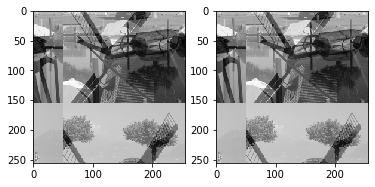

In [52]:
# shifting images on a linear operation
x = lake
y = wm

com1 = imshift(0.5*x+0.5*y, 100, -50)
com2 = 0.5*imshift(x, 100, -50) + 0.5*imshift(y, 100,-50)
# print(com1 == com2)
plt.subplot(1,2,1)
plt.imshow(com1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(com2, cmap='gray')

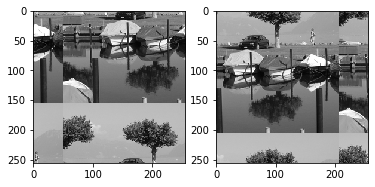

In [59]:
# shifting the image in the direction (k, l), shift it back in the direction ( k, l)
x1 = imshift(x, 100, -50)
x2 = imshift(x1, -50, 100)
plt.subplot(1, 2, 1)
plt.imshow(x1, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(x2, cmap='gray')

## Problem 3 Convolution
In this problem, we intend to explore and implement 2D convolution.

<img src="markdown/conv.png">

First, Create imkernel function that produces a function handle nu implementing a convolution kernel functions on the finite support (-s1, s1)x(-s2, s2). In this case, we specifies the ’gaussian’ kernel as following.

Create imconvolve_naive function that performs(except around boundaries) the convolution between x and v with four loops.

Create imconvolve_spatial function that performs the convolution between x and v including around boundaries. The idea is to switch the k, l loops with the i, j loops, and then make use of imshift. The final code should read with only two loops. 

Write a script test_imconvolve function that compares the results and the execution times of imconvolve_naive and imconvolve_spatial, give comment on the execution times of two methods. You should have similar result like:
<img src="markdown/fig5.png">




Execution Time for naive:  38.519301652908325
Execution Time for spatial:  0.6532015800476074


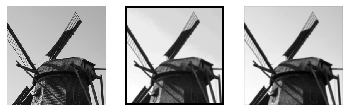

In [199]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
import time

def imkernel(tau, s1, s2):
    w = lambda i,j:np.exp(-(i**2+j**2)/(2*tau**2))
    # normalization
    i,j=np.mgrid[-s1:s1,-s2:s2]
    Z = np.sum(w(i,j))
    nu = lambda i,j: w(i,j)/Z * ((np.absolute(i)<= s1)&(np.absolute(j)<=s2))
    return nu

# Create imconvolve_naive function,
def imconvolve_naive(im, nu, s1, s2):
    start = time.time()

    (n1,n2)=im.shape
#     (s1,s2)=win_size
    xconv = np.zeros((n1,n2))    
    for i in range(s1, n1-s1):
        for j in range(s2, n2-s2):
            for p in range(-s1+1, s1):
                for q in range(-s2+1, s2):
                    xconv[i, j] = int(xconv[i, j] + im[i+p, j+q]*nu(p, q))
    end = time.time()
    print("Execution Time for naive: ", end - start)
    return xconv

#Create imconvolve_spatial function
def imconvolve_spatial(x, nu,s1,s2):
    start = time.time()
    k = np.zeros((2*s1, 2*s2))
    for i in range(2*s1):
        for j in range(2*s2):
            k[i, j] = nu(s1-i, s2-j)
#     print(k)
    
    (n1,n2)=im.shape
    x2 = np.zeros((n1+2*s1, n2+2*s2))
    x2[s1:n1+s1,s2:n2+s2 ] = x[:, :]
    
    xconv = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
                xconv[i, j] = int(np.sum(k*x2[i:i+2*s1, j:j+s2*2]))
    end = time.time()
    print("Execution Time for spatial: ", end - start)
    return xconv

#Create imconvolve_spatial function
# def imconvolve_spatial(im,nu, s1,s2):
#     '''
#     Your code here
#     '''
#     return xconv

#Sample call and Plotting code
tau = 1
s1 = 4
s2 = 4
nu = imkernel(tau, s1, s2)
im = imread('windmill.png')
xconv = imconvolve_naive(im, nu, s1, s2)
xconv2 = imconvolve_spatial(im, nu, s1, s2)

plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(im, cmap='gray')
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(xconv, cmap='gray')
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(xconv2, cmap='gray')

# Execution Time for naive:  21.763076066970825
# Execution Time for spatial:  0.5763585567474365
# spatial convolution is fastest because it uses matrix multiply to calculate, not loops.

## Conclusion

Have you accomplished all parts of your assignment? What concepts did you used or learned in this assignment? What difficulties have you encountered? Explain your result for each section. Please wirte one or two short paragraph in the below Markdown window (double click to edit).

Problem 1: At first, I don't know how to do a sampling and quantization, so I asked lan whether he could give me some examples. And just after he gave me some hints, I understood the points and finished problem 1. Choose 1 from 10 pixels to do a sampling of 10 rating and convert 256 levels to 5 levels to do the quantization. The result is printed and can be easily observed.

Problem 2: It is not difficult for me. I use two methods to complete shift images. 1) use two loops to shift each pixels according to the given rules. 2) move parts of images according to l, k. The former method is more mathematic(numeric?)- you don't need to know what it is but you can use it, and the latter one is more visual- you see what it can do and then code.

Problem 3: I am a little confused. I don't know clearly about the function of imkernel. I thought nu was used to generate a guassian normalized kernel. It should be a 2D matrix and the numbers are distributed according to guassian distribution and sum is 1. But imkernel() didn't generate the kernel I have imagined. So, I presume it may miss brackets since '&' is prior to '<='.
I am also confused about whether my answers are correct. It looks similar but I don't know for sure. 

**** Your Conclusion: ****

Since I am getting used to numpy, imread and matplotlib, I can spend more time considering about the meanings of each problems and how to make my program more efficient with fewer loops and less execution time. Thanks for Lan for helping me out with problem1. 

---
** Submission Instructions**  
Remember to submit you pdf version of this notebook to Gradescope. You can find the export option at File $\rightarrow$ Download as $\rightarrow$ PDF via LaTeX